# Spatio-Temporal Variogram (hourly)

## Clean the data

First, load library and set encoding

In [2]:
library(ggplot2)
library(sqldf)
library(dplyr)
library(sp)
library(spacetime)
Sys.setlocale("LC_CTYPE", "thai")
options(encoding="UTF-8")

Loading required package: gsubfn
Loading required package: proto
Loading required package: RSQLite

Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



[1] "Thai_Thailand.874"

Load and update sensorlist id to the newest. เบอร์ของเก่าปีที่แล้วมันผิด มี 0 เยอะเกิน ต้องแก้ไขก่อน

In [3]:
sensorlist<-read.csv("https://raw.githubusercontent.com/Maplub/MonthlyAirQuality/master/sensorlist.csv",stringsAsFactors = FALSE)
sensorlist[sensorlist$sensorid=="CU-S00054",1]<-"CU-S0054"
sensorlist[sensorlist$sensorid=="CU-S00083",1]<-"CU-S0083"
sensorlist[sensorlist$sensorid=="CU-S00103",1]<-"CU-S0103"
sensorlist[sensorlist$sensorid=="CU-S00104",1]<-"CU-S0104"
sensorlist$sensorid <- as.factor(sensorlist$sensorid)

Load hourly data

In [4]:
hour<-read.csv("https://raw.githubusercontent.com/Maplub/AirQualityData/master/H_Mar_PM25_2561.csv")

In [5]:
head(hour)

sensorid,date,h,pm25
CU-S0002,2018-03-01,9,43.06250
CU-S0002,2018-03-01,10,45.21875
CU-S0002,2018-03-01,11,48.02083
CU-S0002,2018-03-01,12,46.94792
CU-S0002,2018-03-01,13,44.92708
CU-S0002,2018-03-01,14,45.35417


In [6]:
hour[hour$sensorid=="CU-SOO94",1]<-"CU-S0094"

Update time to POSIXct

In [7]:
hour$timepos <- as.POSIXct(strptime(paste(hour$date,hour$h), "%Y-%m-%d %H"))

Select only one day, then order it by timepos and sensorid respectively.

In [29]:
newhour<-hour[hour$timepos>="2018-03-08 00:00:00" & hour$timepos<="2018-03-12 23:00:00",]
newhour <- newhour[order(newhour$timepos, newhour$sensorid),]

Count number of rows per id to check the completeness of data. เช็คว่าข้อมูลทุก sensor มีครบ 24 ชั่วโมงหรือไม่

In [30]:
count<-sqldf("select sensorid,count() from newhour group by sensorid") 
sensorFull <-as.matrix(count[count$c == 24*5,]$sensorid)

Select only sensors that has 24 hour data

In [31]:
newhour<-subset(newhour,sensorid %in% sensorFull)

Check whether there is a weird value in the data.

In [32]:
sqldf("select sensorid, min(pm25), max(pm25), avg(pm25) from newhour group by sensorid")

sensorid,min(pm25),max(pm25),avg(pm25)
CU-S0002,25.00000,211.13542,73.69924
CU-S0003,15.79167,156.92708,64.94887
CU-S0004,20.19792,162.11458,69.84407
CU-S0014,14.23864,109.00000,51.41358
CU-S0015,14.71875,119.69792,52.64406
CU-S0023,30.47917,131.76042,69.24686
CU-S0029,17.34375,132.55208,62.61267
CU-S0042,16.41667,129.73958,58.14111
CU-S0045,15.21875,176.35417,76.76702
CU-S0047,16.32386,128.04167,58.68719


## Input into the model

The model use 3 inputs:
1. Unique datetime list in order (วันที่แบบเรียงลำดับ)
2. Unique sensorid in order (id แบบ เรียงลำดับ)
3. Sensor data order by sensorid and time respectively (ข้อมูลเรียงลำดับตาม id กับ เวลา เพื่อให้เชื่อมกับ 1 กับ 2)

In [33]:
datetime<-sqldf('select distinct(timepos) from newhour') #USE THIS
datetime<-as.data.frame(datetime[order(datetime$timepos),])
colnames(datetime)<-c("timepos")
sensorid<-subset(sensorlist,sensorid %in% sensorFull)
sensorid <- as.data.frame(sensorid[order(sensorid$sensorid),])
row.names(sensorid) = sensorid$sensorid

Create a SpatialPointsDataFrame

In [34]:
coordinates(sensorid)=~lon+lat
proj4string(sensorid)=CRS("+init=epsg:4326")

In [35]:
sensoridSP <- SpatialPoints(sensorid@coords,CRS("+init=epsg:4326")) 

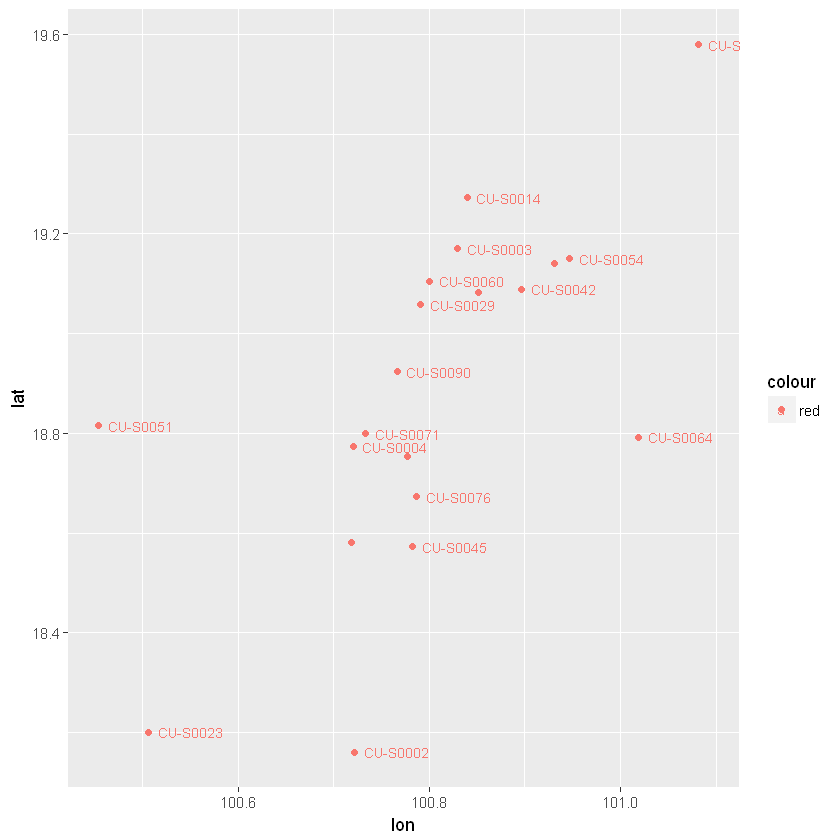

In [36]:
ggplot(data=as.data.frame(sensorid@coords), aes(x=lon, y=lat, color="red",label=rownames(as.data.frame(sensorid@coords))))+geom_point()+geom_text(hjust = 0, nudge_x = 0.01,size=3,check_overlap = TRUE)

Project lat/lon to UTM Zone 47

In [37]:
library(rgdal)
sensoridSP.UTM <- spTransform(sensoridSP, CRS("+init=epsg:32647"))

Create spatio-temporal using STFDF function from spacetime library
STFDF ข้อมูลจะแหว่งไม่ได้เลย

In [38]:
stdata<-STFDF(sensoridSP.UTM,datetime$timepos,data.frame(PM2.5=as.vector(newhour$pm25)),delta(datetime$timepos))

In [39]:
 summary(stdata)

Object of class STFDF
 with Dimensions (s, t, attr): (20, 120, 1)
[[Spatial:]]
Object of class SpatialPoints
Coordinates:
          min       max
lon  653277.9  718387.3
lat 2008840.6 2166302.0
Is projected: TRUE 
proj4string :
[+init=epsg:32647 +proj=utm +zone=47 +datum=WGS84 +units=m +no_defs
+ellps=WGS84 +towgs84=0,0,0]
Number of points: 20
[[Temporal:]]
     Index                       timeIndex     
 Min.   :2018-03-08 00:00:00   Min.   :  1.00  
 1st Qu.:2018-03-09 05:45:00   1st Qu.: 30.75  
 Median :2018-03-10 11:30:00   Median : 60.50  
 Mean   :2018-03-10 11:30:00   Mean   : 60.50  
 3rd Qu.:2018-03-11 17:15:00   3rd Qu.: 90.25  
 Max.   :2018-03-12 23:00:00   Max.   :120.00  
[[Data attributes:]]
     PM2.5       
 Min.   :  7.25  
 1st Qu.: 35.70  
 Median : 57.47  
 Mean   : 62.55  
 3rd Qu.: 82.79  
 Max.   :211.14  

Then plot it

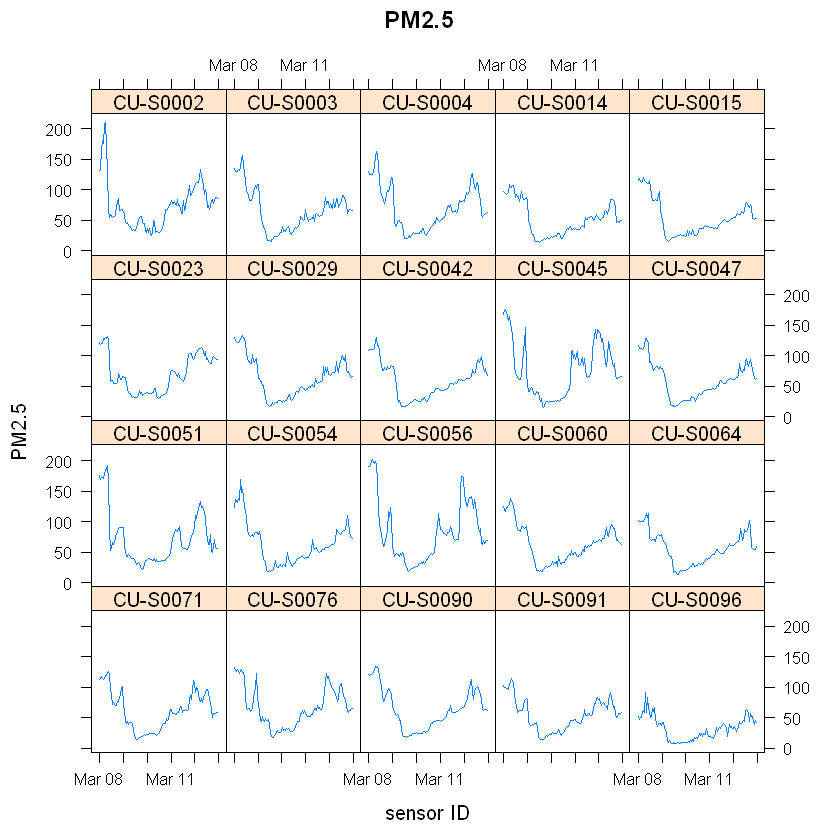

In [40]:
library(RColorBrewer)
colorsetting=brewer.pal(9,"Blues")

scales <- list(x = list(rot = 45))
stplot(stdata,mode="tp",cuts=9,scales=scales,xlab="sensor ID",col.regions = colorsetting)

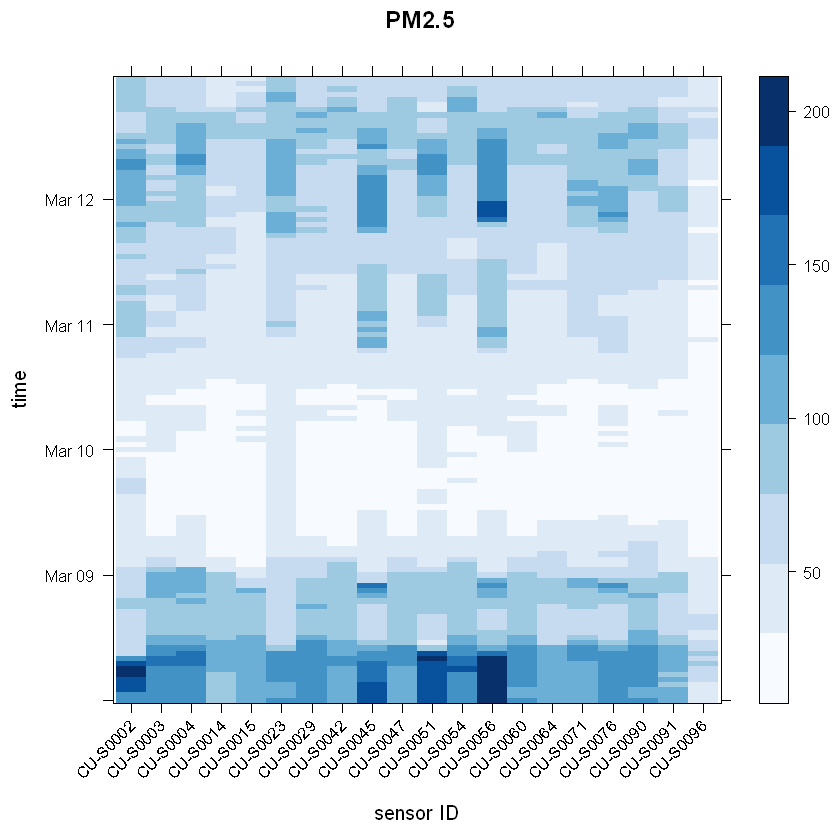

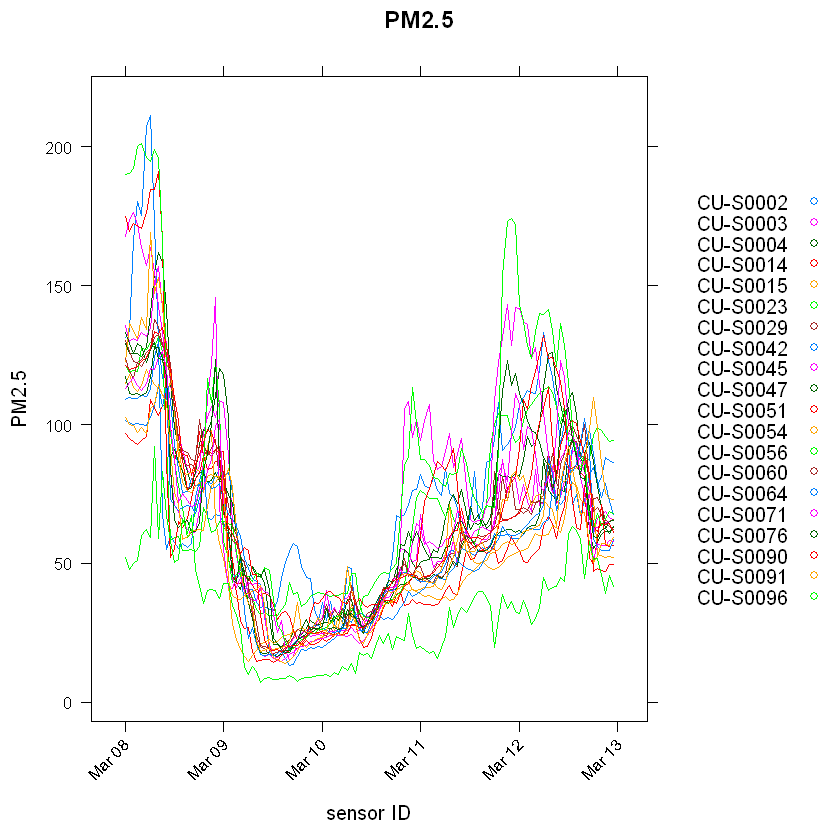

In [41]:
stplot(stdata,mode="xt",cuts=9,scales=scales,xlab="sensor ID",col.regions = colorsetting)
stplot(stdata,mode="ts",scales=scales,xlab="sensor ID",col.regions = colorsetting)

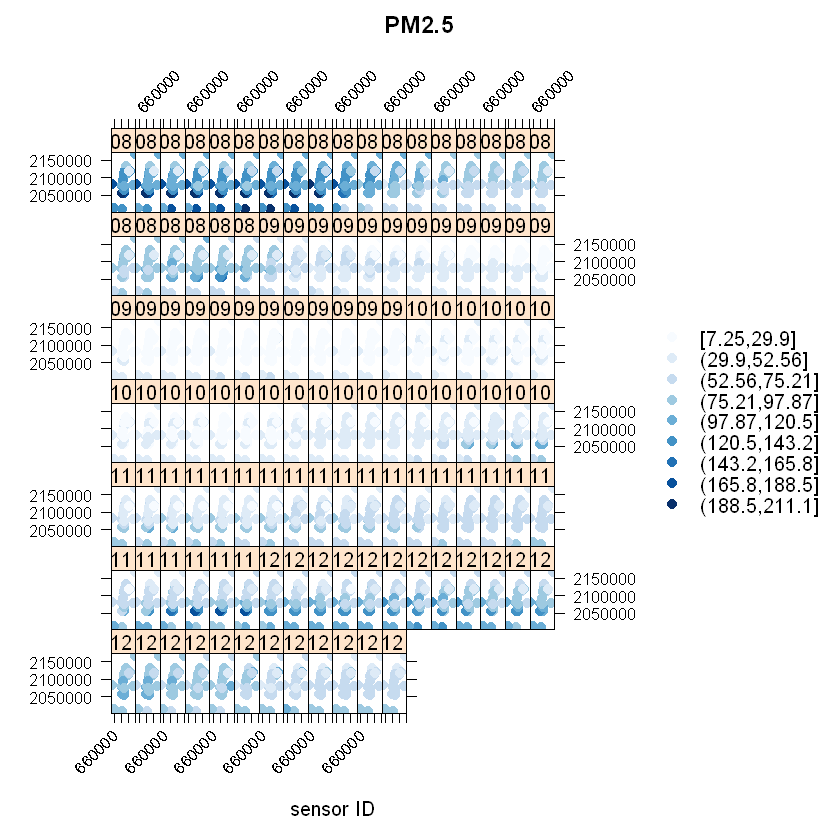

In [42]:
stplot(stdata,cuts=9,scales=scales,xlab="sensor ID",col.regions = colorsetting)

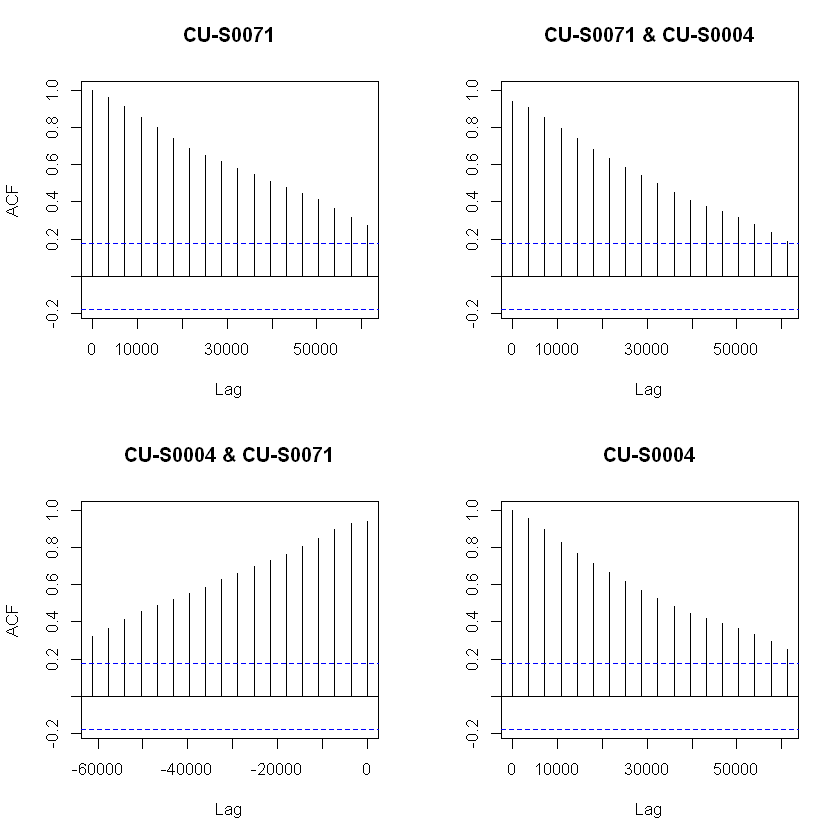

In [43]:
select_sta<-c("CU-S0071","CU-S0004","CU-S0098","CU-S0027")
acf(na.omit(as(stdata[select_sta,],"xts")))

In [44]:
print(spDists(stdata@sp),digits=3)

        [,1]   [,2]  [,3]   [,4]   [,5]   [,6]  [,7]   [,8]   [,9]  [,10]
 [1,]      0 112269 67749 123702 161572  23246 99609 104394  46056 102946
 [2,] 112269      0 45418  11433  52543 112596 13002  11400  66270   9911
 [3,]  67749  45418     0  56731  97058  67285 32451  39616  23080  36939
 [4,] 123702  11433 56731      0  42445 123790 24283  21191  77701  21067
 [5,] 161572  52543 97058  42445      0 164277 65315  57687 115818  60132
 [6,]  23246 112596 67285 123790 164277      0 99594 106646  50511 104208
 [7,]  99609  13002 32451  24283  65315  99594     0  11646  53739   6868
 [8,] 104394  11400 39616  21191  57687 106646 11646      0  58397   4872
 [9,]  46056  66270 23080  77701 115818  50511 53739  58397      0  56891
[10,] 102946   9911 36939  21067  60132 104208  6868   4872  56891      0
[11,]  77725  55690 28425  64884 107315  68245 44497  55575  43753  51187
[12,] 111998  12531 48030  17666  49673 114889 19265   8524  66153  12515
[13,]  46456  66283 21296  77681 11703

In [45]:
dim(stdata)

space      time variables 
       20       120         1

In [69]:
library(gstat)
vv = variogram(PM2.5~1, stdata, width=2500, tlags=0:6)

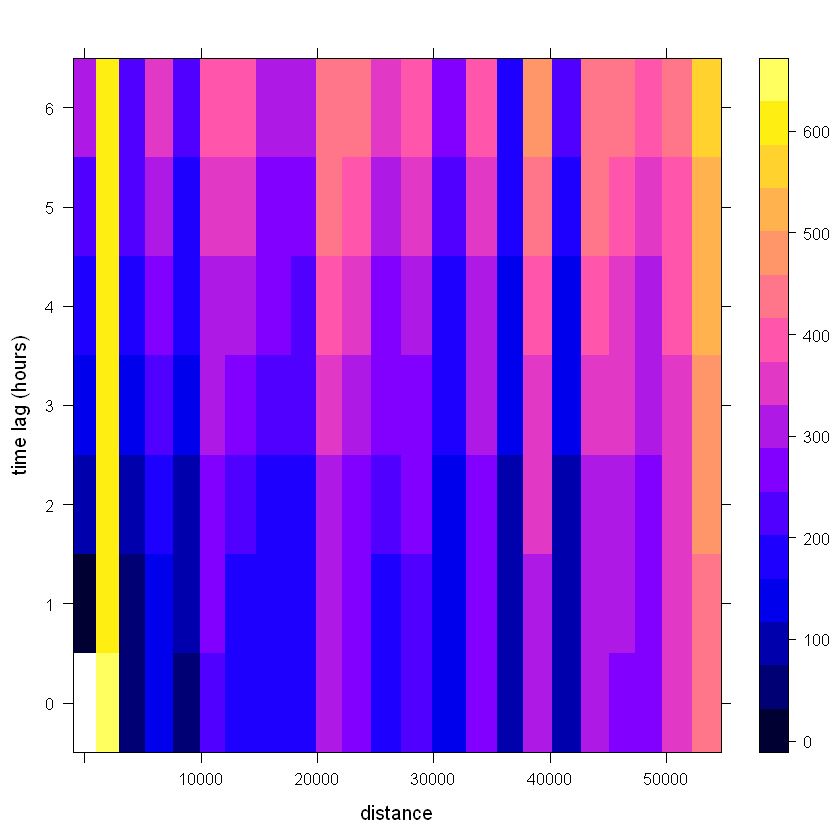

In [70]:
plot(vv)

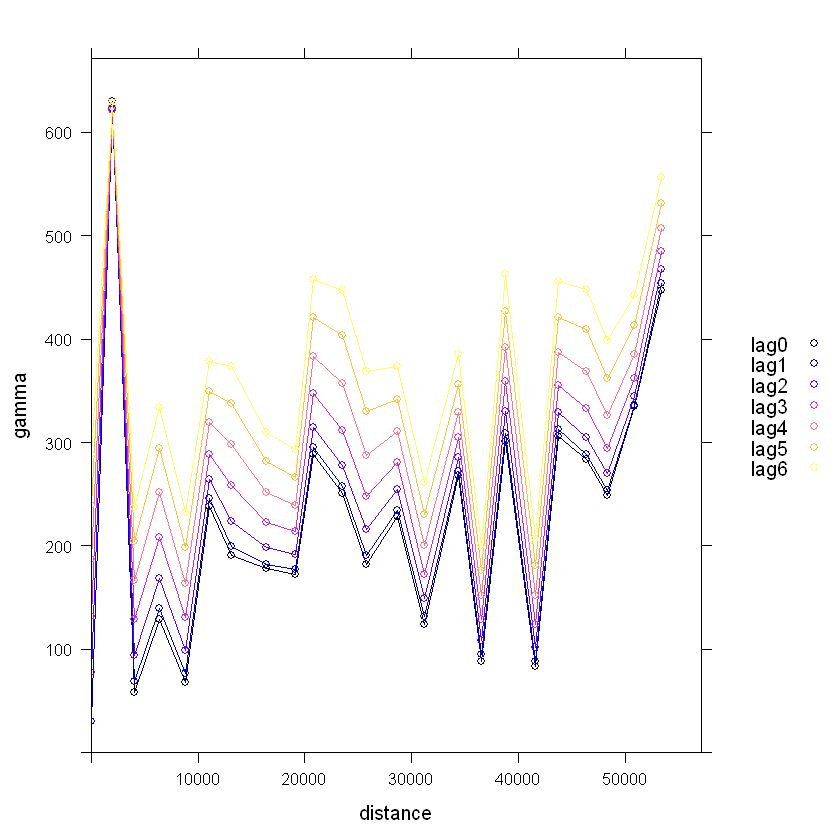

In [71]:
plot(vv, map = FALSE)

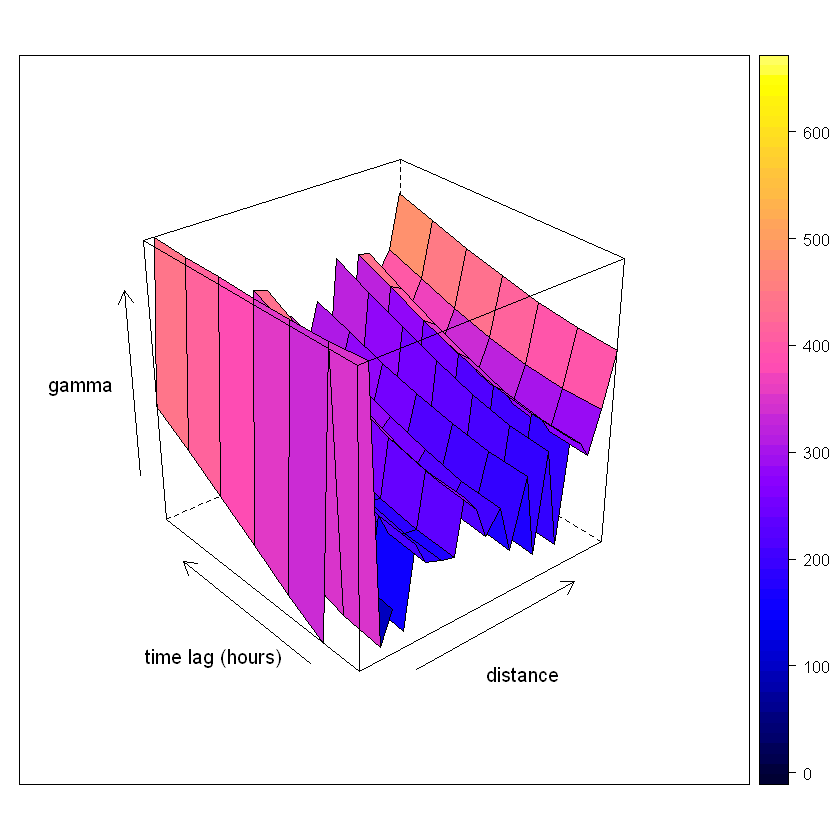

In [72]:
library(lattice)
plot(vv,all=T, wireframe=T)